In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor
from xgboost import plot_importance, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score,explained_variance_score
import warnings  
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

# Data

## Power Consumption data

In [2]:
pjme_df = pd.read_csv('./power_electricity_resampled.csv', parse_dates=[0], index_col=[0])
pjme_df = pjme_df.loc[~pjme_df.index.duplicated(keep='first')].sort_index().dropna()
pjme_df.head()

,electric_power
Datetime,
2017-02-06 07:30:00,26.597063
2017-02-06 08:30:00,30.096608
2017-02-06 09:30:00,30.744339
2017-02-06 10:30:00,30.696277
2017-02-06 11:30:00,29.545297


In [3]:
pjme_df.shape

(11310, 1)

In [4]:
pjme_df.describe()

,electric_power
count,11310.000000
mean,9.306502
std,4.743364
min,5.564006
25%,6.663160
50%,7.435117
75%,9.743601
max,36.533492


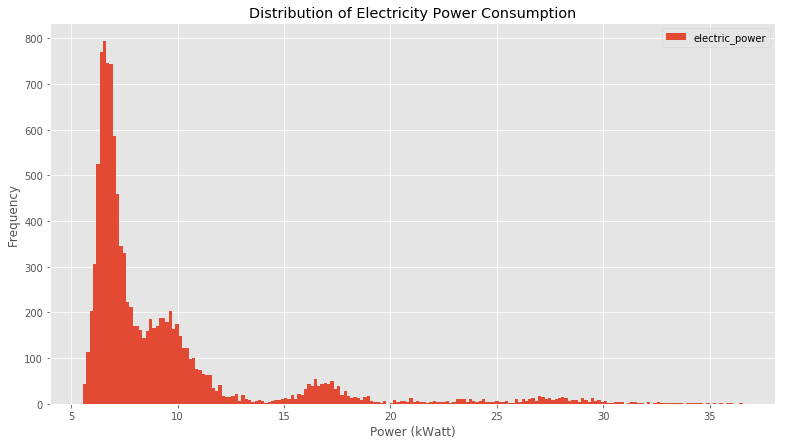

In [5]:
_ = pjme_df.plot.hist(figsize=(13, 7), bins=200, title='Distribution of Electricity Power Consumption')
plt.xlabel('Power (kWatt)')
plt.show()

## Weather Data

### Combine Power and weather data

In [6]:
weather_d = pd.read_csv('./weather.csv', parse_dates=[0], index_col=[0])
weather_d = weather_d.loc[~weather_d.index.duplicated(keep='first')].sort_index().dropna()
weather_d = weather_d.assign(
                                pressure_log = weather_d.Pressure.apply(np.log)
                                )
weather_d.head()

,Temperature,Pressure,Humidity,Wind,Wind_Speed,Forcast,City,pressure_log
Datetime,,,,,,,,
2017-01-03 05:00:00,15.9,758.1,86.0,Wind blowing from the west,3.0,Mist.,Falconara,6.630815
2017-01-03 14:00:00,20.4,760.2,64.0,Wind blowing from the north-west,8.0,,Falconara,6.633582
2017-01-03 20:00:00,16.9,761.4,75.0,Wind blowing from the north-west,7.0,,Falconara,6.635159
2017-01-03 23:00:00,16.4,762.3,74.0,Wind blowing from the north-west,8.0,,Falconara,6.636340
2017-01-04 02:00:00,15.8,761.1,78.0,Wind blowing from the west-northwest,6.0,Clouds generally dissolving or becoming less d...,Falconara,6.634765


In [7]:
weather_d.drop('Forcast', axis=1, inplace=True)
weather_d.head()

,Temperature,Pressure,Humidity,Wind,Wind_Speed,City,pressure_log
Datetime,,,,,,,
2017-01-03 05:00:00,15.9,758.1,86.0,Wind blowing from the west,3.0,Falconara,6.630815
2017-01-03 14:00:00,20.4,760.2,64.0,Wind blowing from the north-west,8.0,Falconara,6.633582
2017-01-03 20:00:00,16.9,761.4,75.0,Wind blowing from the north-west,7.0,Falconara,6.635159
2017-01-03 23:00:00,16.4,762.3,74.0,Wind blowing from the north-west,8.0,Falconara,6.636340
2017-01-04 02:00:00,15.8,761.1,78.0,Wind blowing from the west-northwest,6.0,Falconara,6.634765


In [8]:
weather_d.drop('City', axis=1, inplace=True)
weather_d.head()

,Temperature,Pressure,Humidity,Wind,Wind_Speed,pressure_log
Datetime,,,,,,
2017-01-03 05:00:00,15.9,758.1,86.0,Wind blowing from the west,3.0,6.630815
2017-01-03 14:00:00,20.4,760.2,64.0,Wind blowing from the north-west,8.0,6.633582
2017-01-03 20:00:00,16.9,761.4,75.0,Wind blowing from the north-west,7.0,6.635159
2017-01-03 23:00:00,16.4,762.3,74.0,Wind blowing from the north-west,8.0,6.636340
2017-01-04 02:00:00,15.8,761.1,78.0,Wind blowing from the west-northwest,6.0,6.634765


In [9]:
weather_d.drop('Wind', axis=1, inplace=True)
weather_d.head()

,Temperature,Pressure,Humidity,Wind_Speed,pressure_log
Datetime,,,,,
2017-01-03 05:00:00,15.9,758.1,86.0,3.0,6.630815
2017-01-03 14:00:00,20.4,760.2,64.0,8.0,6.633582
2017-01-03 20:00:00,16.9,761.4,75.0,7.0,6.635159
2017-01-03 23:00:00,16.4,762.3,74.0,8.0,6.636340
2017-01-04 02:00:00,15.8,761.1,78.0,6.0,6.634765


In [10]:

# resample at 1H to average
resample = weather_d.resample('H', loffset='30T').pad()

weather_df = resample.interpolate()

# remove constant points


weather_df.head(50)
weather_df.to_csv('./weather_resampled.csv')

In [11]:
comb_df = pd.concat([pjme_df.loc[weather_df.index[0]:weather_df.index[-1]], weather_df], axis=1).sort_index().dropna()

comb_df.head()

,electric_power,Temperature,Pressure,Humidity,Wind_Speed,pressure_log
Datetime,,,,,,
2017-02-06 07:30:00,26.597063,21.7,760.0,62.0,7.0,6.633318
2017-02-06 08:30:00,30.096608,24.1,762.9,62.0,4.0,6.637127
2017-02-06 09:30:00,30.744339,24.1,762.9,62.0,4.0,6.637127
2017-02-06 10:30:00,30.696277,24.1,762.9,62.0,4.0,6.637127
2017-02-06 11:30:00,29.545297,26.3,763.0,51.0,4.0,6.637258


In [12]:
comb_df.tail()

,electric_power,Temperature,Pressure,Humidity,Wind_Speed,pressure_log
Datetime,,,,,,
2018-10-30 11:30:00,11.071924,27.6,764.3,48.0,4.0,6.63896
2018-10-30 12:30:00,10.741479,27.6,764.3,48.0,4.0,6.63896
2018-10-30 13:30:00,10.163620,27.6,764.3,48.0,4.0,6.63896
2018-10-30 14:30:00,9.992667,27.9,763.2,49.0,5.0,6.63752
2018-10-30 15:30:00,9.924275,27.9,763.2,49.0,5.0,6.63752


### Power and weather data visualization

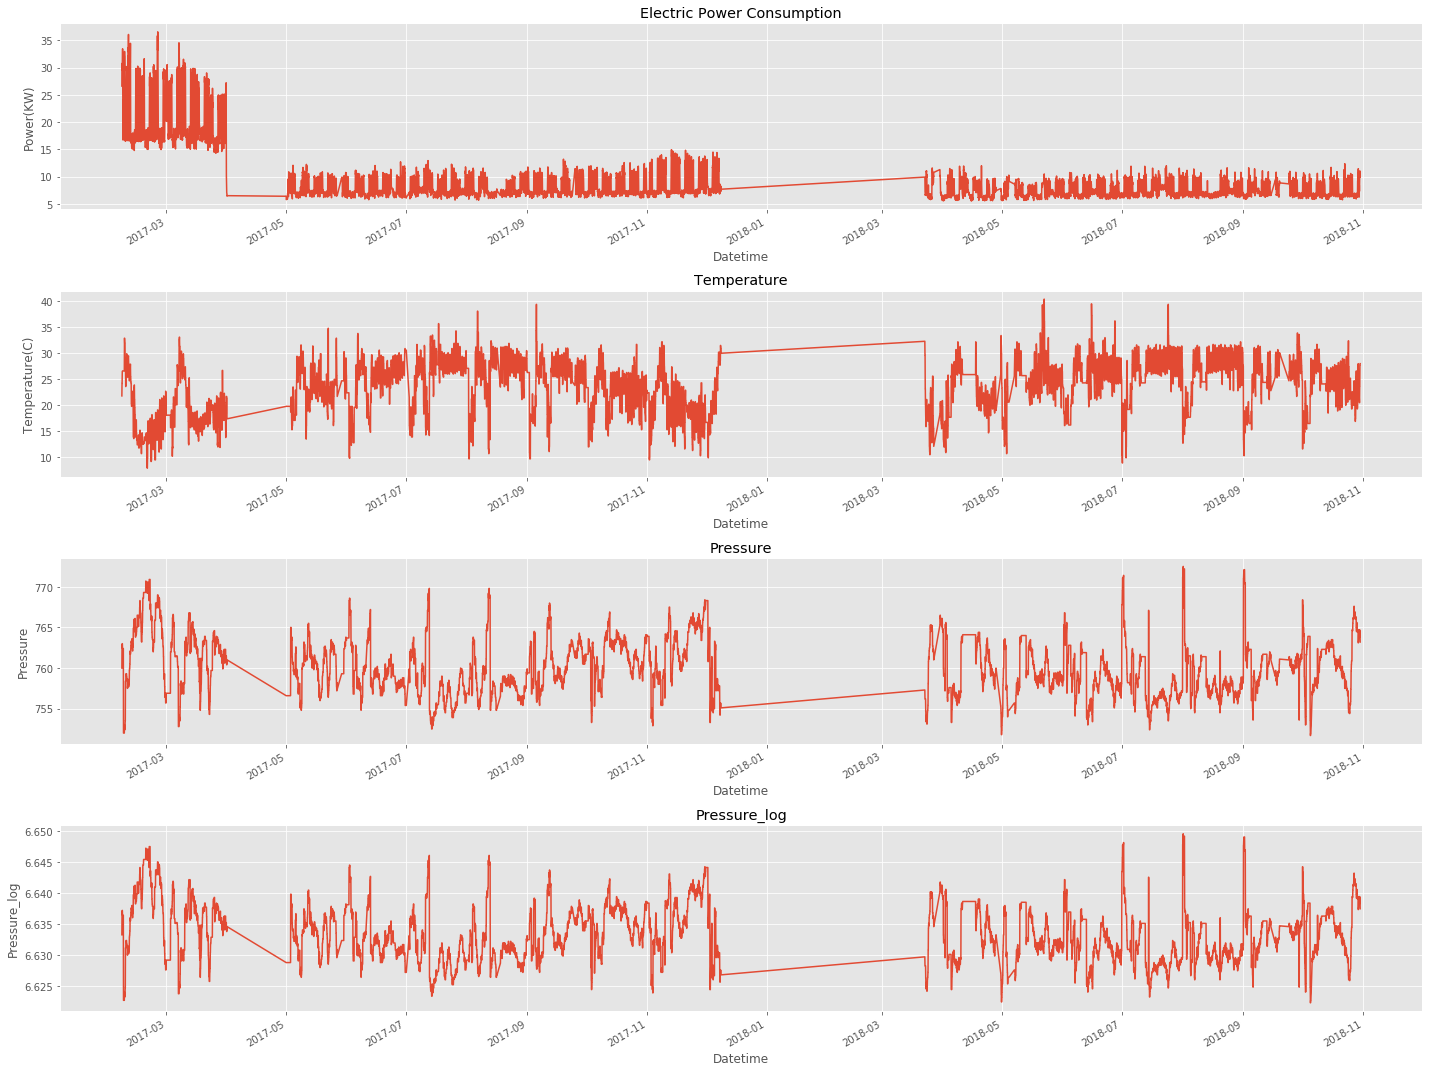

In [13]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(20,15))
axes[0].set_title('Electric Power Consumption')
axes[0].set_ylabel('Power(KW)')
axes[0].set_xlabel('Datetime')
comb_df.electric_power.plot(ax=axes[0])

axes[1].set_title('Temperature')
axes[1].set_ylabel('Temperature(C)')
axes[1].set_xlabel('Datetime')
comb_df.Temperature.plot(ax=axes[1])

axes[2].set_title('Pressure')
axes[2].set_ylabel('Pressure')
axes[2].set_xlabel('Datetime')
comb_df.Pressure.plot(ax=axes[2])

axes[3].set_title('Pressure_log')
axes[3].set_ylabel('Pressure_log')
axes[3].set_xlabel('Datetime')
comb_df.pressure_log.plot(ax=axes[3]                      
                      
                     )

plt.tight_layout()
plt.show()

## Time series features

* Adding time series features.

In [14]:
final_df = (comb_df.assign( day_of_week = comb_df.index.dayofweek
                            ,year = comb_df.index.year
                            ,month = comb_df.index.month
                            ,day = comb_df.index.day
                            ,day_of_year = comb_df.index.dayofyear

                            ,week = comb_df.index.week
                            ,week_day = comb_df.index.weekday_name 
                            ,quarter = comb_df.index.quarter
                            ,hour = comb_df.index.hour
                            ,hour_x = np.sin(2.*np.pi*comb_df.index.hour/24.)
                            ,hour_y = np.cos(2*np.pi*comb_df.index.hour/24.)
                            ,day_of_year_x = np.sin(2.*np.pi*comb_df.index.dayofyear/365.)
                            ,day_of_year_y = np.cos(2.*np.pi*comb_df.index.dayofyear/365.)

                          )
           )

# df['hourfloat']=df.hour+df.minute/60.0
# df['x']=np.sin(2.*np.pi*df.hourfloat/24.)
# df['y']=np.cos(2.*np.pi*df.hourfloat/24.)

In [15]:
final_df.head()

,electric_power,Temperature,Pressure,Humidity,Wind_Speed,pressure_log,day_of_week,year,month,day,day_of_year,week,week_day,quarter,hour,hour_x,hour_y,day_of_year_x,day_of_year_y
Datetime,,,,,,,,,,,,,,,,,,,
2017-02-06 07:30:00,26.597063,21.7,760.0,62.0,7.0,6.633318,0,2017,2,6,37,6,Monday,1,7,0.965926,-0.258819,0.594727,0.803928
2017-02-06 08:30:00,30.096608,24.1,762.9,62.0,4.0,6.637127,0,2017,2,6,37,6,Monday,1,8,0.866025,-0.500000,0.594727,0.803928
2017-02-06 09:30:00,30.744339,24.1,762.9,62.0,4.0,6.637127,0,2017,2,6,37,6,Monday,1,9,0.707107,-0.707107,0.594727,0.803928
2017-02-06 10:30:00,30.696277,24.1,762.9,62.0,4.0,6.637127,0,2017,2,6,37,6,Monday,1,10,0.500000,-0.866025,0.594727,0.803928
2017-02-06 11:30:00,29.545297,26.3,763.0,51.0,4.0,6.637258,0,2017,2,6,37,6,Monday,1,11,0.258819,-0.965926,0.594727,0.803928


## Features correlation heatmap

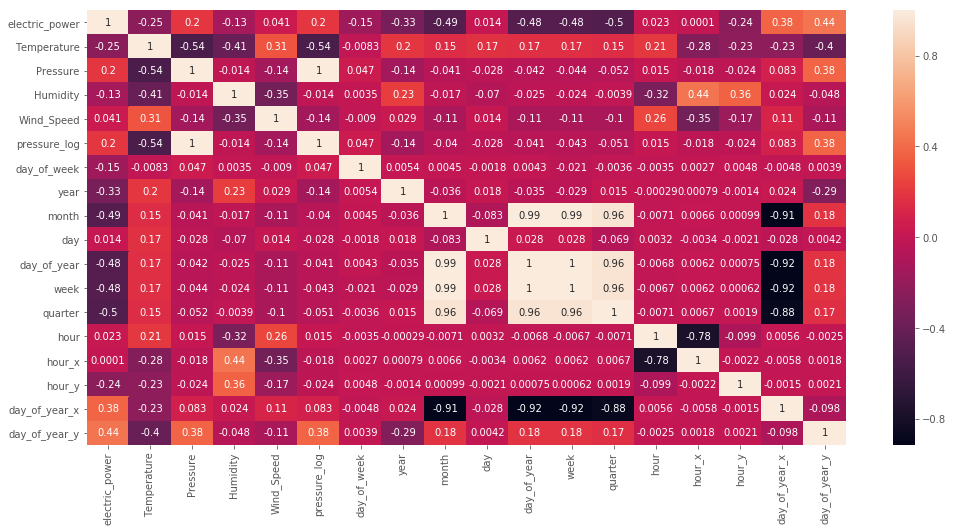

In [16]:
fig, ax = plt.subplots(figsize = (17,8))
corr = final_df.corr()
ax = sns.heatmap(corr, annot=True,
            xticklabels = corr.columns.values,
            yticklabels = corr.columns.values)
plt.show()

* **Power consumption** is highly correlated to the **hour**.

## Regression Models

In [17]:
final_df.head()


,electric_power,Temperature,Pressure,Humidity,Wind_Speed,pressure_log,day_of_week,year,month,day,day_of_year,week,week_day,quarter,hour,hour_x,hour_y,day_of_year_x,day_of_year_y
Datetime,,,,,,,,,,,,,,,,,,,
2017-02-06 07:30:00,26.597063,21.7,760.0,62.0,7.0,6.633318,0,2017,2,6,37,6,Monday,1,7,0.965926,-0.258819,0.594727,0.803928
2017-02-06 08:30:00,30.096608,24.1,762.9,62.0,4.0,6.637127,0,2017,2,6,37,6,Monday,1,8,0.866025,-0.500000,0.594727,0.803928
2017-02-06 09:30:00,30.744339,24.1,762.9,62.0,4.0,6.637127,0,2017,2,6,37,6,Monday,1,9,0.707107,-0.707107,0.594727,0.803928
2017-02-06 10:30:00,30.696277,24.1,762.9,62.0,4.0,6.637127,0,2017,2,6,37,6,Monday,1,10,0.500000,-0.866025,0.594727,0.803928
2017-02-06 11:30:00,29.545297,26.3,763.0,51.0,4.0,6.637258,0,2017,2,6,37,6,Monday,1,11,0.258819,-0.965926,0.594727,0.803928


## Lagging features


In [25]:

# Build lagged weather predictors.
# lagged_df = comb_df.loc[comb_df.index.min().ceil('D'):].copy()
lagged_df = final_df.copy()

# Next day's load values.
lagged_df['load_tomorrow'] = lagged_df['electric_power'].shift(-24)    

for day in range(8):
    lagged_df['Temperature_d' + str(day)] = lagged_df.Temperature.shift(24*day)
    lagged_df['Wind_speed_d' + str(day)] = lagged_df.Wind_Speed.shift(24*day)
    lagged_df['humidity_d' + str(day)] = lagged_df.Humidity.shift(24*day)
    lagged_df['pressure_log_d' + str(day)] = lagged_df.pressure_log.shift(24*day)

    
    
    lagged_df['load_d' + str(day)] = lagged_df.electric_power.shift(24*day)

     
lagged_df = lagged_df.dropna()
    

lagged_df = lagged_df.drop(columns=['Temperature', 'Wind_Speed', 'Humidity', 'Pressure','pressure_log' ,'week_day','electric_power'])
# lagged_df.iloc[50:80]


In [26]:
lagged_df.tail(5)

,day_of_week,year,month,day,day_of_year,week,quarter,hour,hour_x,hour_y,...,Temperature_d6,Wind_speed_d6,humidity_d6,pressure_log_d6,load_d6,Temperature_d7,Wind_speed_d7,humidity_d7,pressure_log_d7,load_d7
Datetime,,,,,,,,,,,,,,,,,,,,,
2018-10-29 11:30:00,0,2018,10,29,302,44,4,11,2.588190e-01,-0.965926,...,22.3,1.0,78.0,6.631211,9.698699,28.7,4.0,52.0,6.632002,10.791823
2018-10-29 12:30:00,0,2018,10,29,302,44,4,12,1.224647e-16,-1.000000,...,22.3,1.0,78.0,6.631211,9.538340,28.7,4.0,52.0,6.632002,10.874629
2018-10-29 13:30:00,0,2018,10,29,302,44,4,13,-2.588190e-01,-0.965926,...,22.3,1.0,78.0,6.631211,8.993180,28.7,4.0,52.0,6.632002,11.223755
2018-10-29 14:30:00,0,2018,10,29,302,44,4,14,-5.000000e-01,-0.866025,...,29.3,4.0,54.0,6.630288,8.663304,28.7,4.0,52.0,6.632002,10.997043
2018-10-29 15:30:00,0,2018,10,29,302,44,4,15,-7.071068e-01,-0.707107,...,29.3,4.0,54.0,6.630288,8.668408,28.7,4.0,52.0,6.632002,10.368045


In [28]:
X = lagged_df.drop(columns=['load_tomorrow','pressure_log','day_of_week'])
y = lagged_df['load_tomorrow','pressure_log','day_of_week']

KeyError: "['pressure_log'] not found in axis"

In [29]:
X.shape

(11118, 51)

In [30]:
X.head(5)

,year,month,day,day_of_year,week,quarter,hour,hour_x,hour_y,day_of_year_x,...,Temperature_d6,Wind_speed_d6,humidity_d6,pressure_log_d6,load_d6,Temperature_d7,Wind_speed_d7,humidity_d7,pressure_log_d7,load_d7
Datetime,,,,,,,,,,,,,,,,,,,,,
2017-02-13 07:30:00,2017,2,13,44,7,1,7,0.965926,-0.258819,0.687053,...,26.5,3.0,81.0,6.622736,23.724793,21.7,7.0,62.0,6.633318,26.597063
2017-02-13 08:30:00,2017,2,13,44,7,1,8,0.866025,-0.500000,0.687053,...,26.5,3.0,81.0,6.622736,29.001268,24.1,4.0,62.0,6.637127,30.096608
2017-02-13 09:30:00,2017,2,13,44,7,1,9,0.707107,-0.707107,0.687053,...,26.5,3.0,81.0,6.622736,29.602776,24.1,4.0,62.0,6.637127,30.744339
2017-02-13 10:30:00,2017,2,13,44,7,1,10,0.500000,-0.866025,0.687053,...,26.5,3.0,81.0,6.622736,30.570478,24.1,4.0,62.0,6.637127,30.696277
2017-02-13 11:30:00,2017,2,13,44,7,1,11,0.258819,-0.965926,0.687053,...,26.5,3.0,81.0,6.622736,28.461510,26.3,4.0,51.0,6.637258,29.545297


In [31]:
y.shape

NameError: name 'y' is not defined

In [ ]:
y.head(5)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [ ]:
def plot_prediction(actual, prediction, start_date, end_date, title, prediction_label):
    plt.figure(figsize=(20,5))
    plt.title(title)
    plt.plot(y_test.index, y_test, label='Actual')
    plt.plot(y_test.index, prediction, label=prediction_label)
    plt.ylabel('Power(KW)')
    plt.xlabel('Datetime')
    plt.legend()
    plt.xlim(left= start_date, right=end_date)
    plt.show()
    
def subplot_prediction(actual, prediction,prediction_label):
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(20, 15))
    
    con_df = pd.concat([actual.rename('Actual'),pd.DataFrame(prediction, index=actual.index, columns=[prediction_label])], axis=1)
    axes[0].set_title('Actual vs Prediction - One day')
    axes[0].set_ylabel('Power(KW)')
    axes[0].set_xlabel('Datetime')
    con_df.plot(ax=axes[0])
    axes[0].set_xlim(left=con_df.index[-24*1] , right=con_df.index[-1])
    
    axes[1].set_title('Actual vs Prediction - One week')
    axes[1].set_ylabel('Power(KW)')
    axes[1].set_xlabel('Datetime')
    con_df.plot(ax=axes[1])
    axes[1].set_xlim(left=actual.index[-24*7] , right=actual.index[-1])
    
    axes[2].set_title('Actual vs Prediction - One month')
    axes[2].set_ylabel('Power(KW)')
    axes[2].set_xlabel('Datetime')
    con_df.plot(ax=axes[2])
    axes[2].set_xlim(left=actual.index[-24*7*4] , right=actual.index[-1])
    
    plt.tight_layout()
    plt.show()
    
def plot_feature_importances( clf, X_train, y_train=None
                             ,top_n=10, figsize=(10,18), print_table=False, title="Feature Importances"):
    feat_imp = pd.DataFrame({'importance':clf.feature_importances_})    
    feat_imp['feature'] = X_train.columns
    feat_imp.sort_values(by='importance', ascending=False, inplace=True)
    feat_imp = feat_imp.iloc[:top_n]
    
    feat_imp.sort_values(by='importance', inplace=True)
    feat_imp = feat_imp.set_index('feature', drop=True)
    feat_imp.plot.barh(title=title, figsize=figsize)
    plt.xlabel('Feature Importance Score')
    plt.show()
    
    if print_table:
        from IPython.display import display
        print("Top {} features in descending order of importance".format(top_n))
        display(feat_imp.sort_values(by='importance', ascending=False))
        
    return feat_imp


In [ ]:
reg = xgb.XGBRegressor()

In [ ]:
tscv = TimeSeriesSplit(n_splits=20)
scores = cross_val_score(reg, X.values, y.values, cv=tscv
                         ,scoring='explained_variance'
                        )
print("Accuracy: %0.2f " % (scores.mean()))
print(scores)

In [ ]:
reg.fit(X_train,y_train)
prediction = reg.predict(X_test)
print("R2 Score :%0.2f "% r2_score(y_test,prediction))



In [ ]:
_ = plot_feature_importances(reg, X_train, y_train, top_n=X_train.shape[1], title=reg.__class__.__name__, print_table=True)


In [ ]:
comb_df.head()

In [ ]:
def get_features(date, comb_df):
    features = comb_df.loc[date]
    features = (features.assign(
                                day_of_week = features.index.dayofweek
                                ,year = features.index.year
                                ,month = features.index.month
                                ,day = features.index.day
                                ,day_of_year = features.index.dayofyear
                                ,week = features.index.week
#                                             ,week_day = features.index.weekday_name 
                                ,quarter = features.index.quarter
                                ,hour = features.index.hour
                                ,hour_x = np.sin(2.*np.pi*features.index.hour/24.)
                                ,hour_y = np.cos(2*np.pi*features.index.hour/24.)
                                ,day_of_year_x = np.sin(2.*np.pi*features.index.dayofyear/365.)
                                ,day_of_year_y = np.cos(2.*np.pi*features.index.dayofyear/365.)
                                
                                ))
    
    for day in range(8):
        features['Temperature_d' + str(day)] = comb_df.Temperature.shift(24*day)
        features['Wind_Speed_d' + str(day)] = comb_df.Wind_Speed.shift(24*day)
        features['Humidity_d' + str(day)] = comb_df.Humidity.shift(24*day)
        features['pressure_log_d' + str(day)] = comb_df.pressure_log.shift(24*day)



        features['load_d' + str(day)] = comb_df.electric_power.shift(24*day)

    features = features.dropna()
    
    features = features.drop(columns=['Temperature', 'Wind_Speed', 'Humidity', 'Pressure', 'electric_power'])

    return features




In [ ]:
def get_features(date, comb_df):
    features = comb_df.loc[date]
    features = (features.assign(
                                day_of_week = features.index.dayofweek
                                ,year = features.index.year
                                ,month = features.index.month
                                ,day = features.index.day
                                ,day_of_year = features.index.dayofyear
                                ,week = features.index.week
#                                             ,week_day = features.index.weekday_name 
                                ,quarter = features.index.quarter
                                ,hour = features.index.hour
                                ,hour_x = np.sin(2.*np.pi*features.index.hour/24.)
                                ,hour_y = np.cos(2*np.pi*features.index.hour/24.)
                                ,day_of_year_x = np.sin(2.*np.pi*features.index.dayofyear/365.)
                                ,day_of_year_y = np.cos(2.*np.pi*features.index.dayofyear/365.)
                                
                                ))
    
    for day in range(8):
        features['Temperature_d' + str(day)] = comb_df.Temperature.shift(24*day)
        features['Wind_speed_d' + str(day)] = comb_df.Wind_Speed.shift(24*day)
        features['Humidity_d' + str(day)] = comb_df.Humidity.shift(24*day)
        features['pressure_log_d' + str(day)] = comb_df.pressure_log.shift(24*day)



        features['load_d' + str(day)] = comb_df.electric_power.shift(24*day)

    features = features.dropna()
    
    features = features.drop(columns=['Temperature', 'Wind_Speed', 'Humidity', 'Pressure','electric_power'])

    return features




# Regression Models

In [ ]:
X = final_df.drop(columns = ['electric_power','week_day'])
y = final_df['electric_power']

In [ ]:
X.shape

In [ ]:
y.shape

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

## XGB Model


In [ ]:
reg = xgb.XGBRegressor()

In [ ]:
tscv = TimeSeriesSplit(n_splits=20)
scores = cross_val_score(reg, X.values, y.values, cv=tscv
                         ,scoring='explained_variance'
                        )
print("Accuracy: %0.2f " % (scores.mean()))
print(scores)

In [ ]:
reg.fit(X_train,y_train)
prediction = reg.predict(X_test)
print("R2 Score :%0.2f "% r2_score(y_test,prediction))

In [ ]:
_ = plot_importance(reg, height=0.9)

In [ ]:
subplot_prediction(y_test, prediction,prediction_label='XGB model prediction')

# AdaBoost Model

In [ ]:
reg = AdaBoostRegressor()

In [ ]:
tscv = TimeSeriesSplit(n_splits=20)
scores = cross_val_score(reg, X, y, cv=tscv
                         , scoring='explained_variance'
                        )
print("Accuracy: %0.2f" % (scores.mean() ))
reg.fit(X_train,y_train)
prediction = reg.predict(X_test)
print("R2 Score :%0.2f "% r2_score(y_test,prediction))

In [ ]:
reg.fit(X_train,y_train)
prediction = reg.predict(X_test)
print("R2 Score :%0.2f "% r2_score(y_test,prediction))

In [ ]:
_ = plot_feature_importances(reg, X_train, y_train, top_n=X_train.shape[1], title=reg.__class__.__name__)

In [ ]:
subplot_prediction(y_test, prediction,prediction_label='AdaBoost model prediction')

# Bagging Regressor Model

In [ ]:
reg = BaggingRegressor()

In [ ]:
tscv = TimeSeriesSplit(n_splits=20)
scores = cross_val_score(reg, X, y, cv=tscv
                         , scoring='explained_variance'
                        )
print("Accuracy: %0.2f" % (scores.mean() ))
reg.fit(X_train,y_train)
prediction = reg.predict(X_test)
print("R2 Score :%0.2f "% r2_score(y_test,prediction))

In [ ]:
reg.fit(X_train,y_train)
prediction = reg.predict(X_test)

In [ ]:
subplot_prediction(y_test, prediction,prediction_label='Bagging Regressor model prediction')

# Extra Trees Regressosr Model

In [ ]:
reg = ExtraTreesRegressor()

In [ ]:
tscv = TimeSeriesSplit(n_splits=20)
scores = cross_val_score(reg, X, y, cv=tscv
                         , scoring='explained_variance'
                        )
print("Accuracy: %0.2f" % (scores.mean() ))
reg.fit(X_train,y_train)
prediction = reg.predict(X_test)
print("R2 Score :%0.2f "% r2_score(y_test,prediction))

In [ ]:
reg.fit(X_train,y_train)
prediction = reg.predict(X_test)

In [ ]:
_ = plot_feature_importances(reg, X_train, y_train, top_n=X_train.shape[1], title=reg.__class__.__name__)

In [ ]:
subplot_prediction(y_test, prediction,prediction_label='ExtraTrees Regressor model prediction')

## Multistep Prediction

In [ ]:
final_df.head()

In [ ]:
date = '2018-08-01'
weather_df.loc[date].head()

In [ ]:
def get_features(date):
    features = weather_df.loc[date]
    features = (features.assign(
                                day_of_week = features.index.dayofweek
                                ,year = features.index.year
                                ,month = features.index.month
                                ,day = features.index.day
                                ,day_of_year = features.index.dayofyear
                                ,week = features.index.week
#                                             ,week_day = features.index.weekday_name 
                                ,quarter = features.index.quarter
                                ,hour = features.index.hour
                                ,hour_x = np.sin(2.*np.pi*features.index.hour/24.)
                                ,hour_y = np.cos(2*np.pi*features.index.hour/24.)
                                ,day_of_year_x = np.sin(2.*np.pi*features.index.dayofyear/365.)
                                ,day_of_year_y = np.cos(2.*np.pi*features.index.dayofyear/365.)
                                ))
    return features

In [ ]:
prediction = reg.predict(get_features(date))
idx = comb_df.electric_power.loc[date].index 


In [ ]:
def plot_prediction_multistep(actual, prediction, start_date, title, prediction_label):
    date_rng = pd.date_range(start=start_date, periods=24, freq='H')
    plt.figure(figsize=(20,5))
    plt.title(title)
    plt.plot(actual.index, actual, label='Actual')
    plt.plot(actual.index, prediction, label=prediction_label)
    plt.ylabel('Power(KW)')
    plt.xlabel('Datetime')
    plt.legend()
    plt.show()

In [ ]:
plot_prediction_multistep(actual=comb_df.electric_power.loc[date],prediction=prediction, start_date=date, title='Multistep prediction - 24 hours a head',
                prediction_label='ExtraTrees Regressor model prediction')

In [ ]:
comb_df.tail()